<a href="https://colab.research.google.com/github/gnikhilchand/PINNS/blob/main/PINNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow numpy matplotlib
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


# Physics-Informed Neural Network (PINN)

## Inputs and Outputs
### Inputs (𝑋): Spatial coordinates and time (𝑥,𝑦,𝑡)
### Outputs (𝑌): Velocity components (𝑢,𝑣) and pressure 𝑝.

In [ ]:
# Generate synthetic data for fluid dynamics (e.g., velocity and pressure)
def generate_synthetic_data(num_points=1000):
    x = np.random.uniform(0, 1, num_points)
    y = np.random.uniform(0, 1, num_points)
    t = np.random.uniform(0, 1, num_points)

    # Simple synthetic velocity field u, v and pressure p
    u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.exp(-t)
    v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.exp(-t)
    p = np.cos(np.pi * x) * np.cos(np.pi * y)

    return x, y, t, u, v, p

# Data: x, y coordinates, time t, and their respective velocity and pressure
x, y, t, u, v, p = generate_synthetic_data()


# Neural Network Architecture

### Input Layer: 3 neurons (𝑥,𝑦,𝑡).
### Hidden Layers: Multiple layers with activation functions (e.g., tanh).
### Output Layer: 3 neurons (𝑢,𝑣,𝑝).

In [ ]:
# Neural network architecture for PINNs
def build_pinn():
    input_layer = layers.Input(shape=(3,))  # x, y, t

    x = layers.Dense(50, activation='tanh')(input_layer)
    x = layers.Dense(50, activation='tanh')(x)
    x = layers.Dense(50, activation='tanh')(x)

    # Outputs: u (velocity-x), v (velocity-y), p (pressure)
    u = layers.Dense(1, name='u')(x)
    v = layers.Dense(1, name='v')(x)
    p = layers.Dense(1, name='p')(x)

    model = models.Model(inputs=input_layer, outputs=[u, v, p])
    return model

model = build_pinn()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 50)             │            200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 50)             │          2,550 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 50)             │          2,550 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ u (Dense)                 │ (None, 1)              │             51 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v (Dense)                 │ (None, 1)              │             51 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p (Dense)                 │ (None, 1)              │             51 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,453 (21.30 KB)

 Trainable params: 5,453 (21.30 KB)

 Non-trainable params: 0 (0.00 B)

## The neural network approximates the solution as: Y=N(x,y,t;θ)

## N is the neural network function.
## 𝜃 represents the network parameters (weights and biases).


In [ ]:
tf.config.run_functions_eagerly(True)


# Loss Function

### The loss function in PINNs combines both data-driven loss and physics-based loss

### Total Physics-Based Loss𝐿 physics = 𝐿 continuity + 𝐿 momentum𝑥 + 𝐿 momentum𝑦

### Total Loss (𝐿)=𝐿data + 𝐿physics




In [ ]:
# Physics-informed loss function (Navier-Stokes equations)
def pinn_loss(y_true, y_pred):
    # Unpack the true values (expected shape: list of [u_true, v_true, p_true])
    u_true, v_true, p_true = y_true[0], y_true[1], y_true[2]

    # Physical constants (e.g., viscosity)
    nu = 0.01

    # Convert input arrays into TensorFlow tensors
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
    t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)

    # Stack the inputs to form a single tensor for prediction
    input_tensor = tf.stack([x_tensor, y_tensor, t_tensor], axis=1)

    # Compute the partial derivatives using GradientTape
    with tf.GradientTape(persistent=True) as tape:
        # tape.watch([x_tensor, y_tensor, t_tensor])
        tape.watch(input_tensor)

        # Recompute predictions to ensure gradients are traced properly
        predictions = model(input_tensor)
        if isinstance(predictions, list):
            u_pred, v_pred, p_pred = predictions[0], predictions[1], predictions[2]
        else:
            u_pred, v_pred, p_pred = predictions[:, 0], predictions[:, 1], predictions[:, 2]

    # Compute gradients of u and v with respect to x and y
    u_x = tape.gradient(u_pred, input_tensor)[:,0] # Calculate gradients with respect to the input tensor
    u_y = tape.gradient(u_pred, input_tensor)[:,1]
    v_x = tape.gradient(v_pred, input_tensor)[:,0]
    v_y = tape.gradient(v_pred, input_tensor)[:,1]

    # Ensure gradients are not None
    if u_x is None or v_y is None:
        raise ValueError("Gradient calculation failed: u_x or v_y is None. Ensure that input tensors are properly watched by GradientTape.")

    # Pressure derivatives
    p_x = tape.gradient(p_pred, input_tensor)[:,0]
    p_y = tape.gradient(p_pred, input_tensor)[:,1]

    # Continuity equation
    continuity_loss = u_x + v_y

    # Momentum equation (Navier-Stokes equations)
    momentum_x = u_pred * u_x + v_pred * u_y + p_x - nu * (u_x + u_y)
    momentum_y = u_pred * v_x + v_pred * v_y + p_y - nu * (v_x + v_y)

    # Combine data loss and physics-based loss
    data_loss = tf.reduce_mean(tf.square(u_true - u_pred)) + \
                tf.reduce_mean(tf.square(v_true - v_pred)) + \
                tf.reduce_mean(tf.square(p_true - p_pred))

    physics_loss = tf.reduce_mean(tf.square(continuity_loss)) + \
                   tf.reduce_mean(tf.square(momentum_x)) + \
                   tf.reduce_mean(tf.square(momentum_y))

    total_loss = data_loss + physics_loss
    return total_loss


## Data-Driven Loss (𝐿data)
the network's predictions match the observed data.


### Training the Model
The model is trained using synthetic data and the custom physics-informed loss function. The model adjusts its parameters to minimize both data loss and the physics-based loss.

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=pinn_loss)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 445ms/step - loss: 4.4825
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.7383
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2875
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3422
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2472
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3371
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5470
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2586
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6564
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5822


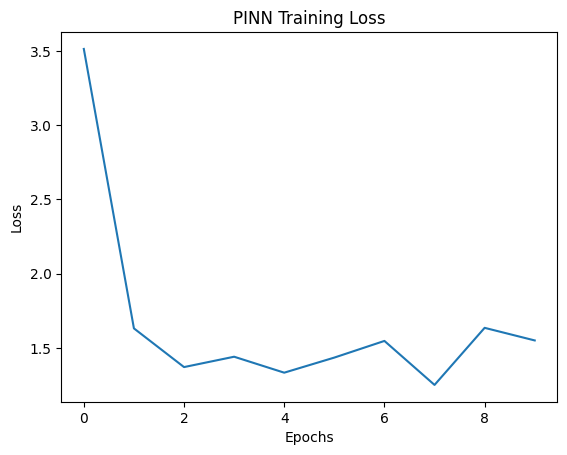

In [ ]:
# Data: x, y coordinates, time t, and their respective velocity and pressure
x, y, t, u, v, p = generate_synthetic_data()
# Combine the data into input tensors
inputs = np.stack([x, y, t], axis=1)  # Combine x, y, and t into a single input
outputs = [u, v, p]

# Train the model
history = model.fit(inputs, outputs, epochs=10, batch_size=64)

# Plot training loss
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PINN Training Loss')
plt.show()

# Predictions and Visualizations

In [ ]:
# Predict on new data points
x_test, y_test, t_test, _, _, _ = generate_synthetic_data(200)
inputs_test = np.stack([x_test, y_test, t_test], axis=1)

u_pred, v_pred, p_pred = model.predict(inputs_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


### Predicted velocity field: Velocity vectors (𝑢pred,𝑣pred) are plotted as quivers on the (𝑥,𝑦)-plane.
### Predicted pressure field: The predicted pressure 𝑝pred​ is visualized as a color-mapped scatter plot over the (𝑥,𝑦)-plane.

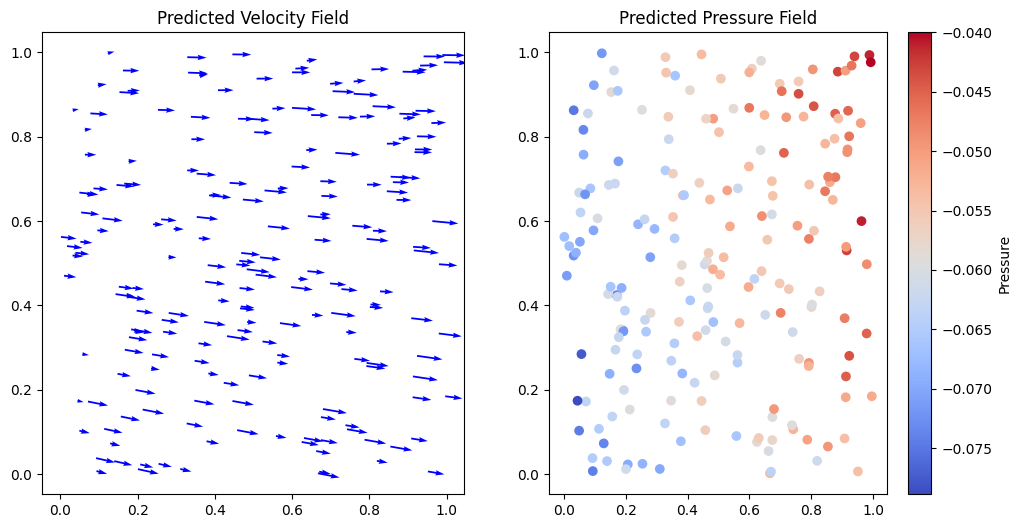

In [ ]:
# Plot predicted velocity field (u, v) and pressure (p)
plt.figure(figsize=(12, 6))

# Velocity field
plt.subplot(1, 2, 1)
plt.quiver(x_test, y_test, u_pred, v_pred, color='blue')
plt.title('Predicted Velocity Field')

# Pressure field
plt.subplot(1, 2, 2)
plt.scatter(x_test, y_test, c=p_pred, cmap='coolwarm')
plt.colorbar(label='Pressure')
plt.title('Predicted Pressure Field')

plt.show()